### import data

#### save as dataframe called raw

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB         # Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer

%matplotlib inline

In [2]:
raw = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
 
 
raw.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### Data Cleaning

#### Drop and rename variables

In [3]:
raw = raw.drop([
'Unnamed: 0'], axis=1)

In [4]:
raw.rename(columns={
    'Clothing ID': 'ID',
    'Age': 'AGE',
    'Title': 'TITLE',
    'Review Text': 'REVIEW',
    'Rating': 'RATING',
    'Recommended IND': 'RECOMMENDED',
    'Positive Feedback Count': 'POS_FEEDBACK',
    'Division Name': 'DIVISION',
    'Department Name': 'DEPARTMENT',
    'Class Name': 'CLASS',}, inplace=True)

#### identify missing values - if REVIEW is blank then delete observation, otherwise fill/ignore

In [5]:
print(raw.isnull().sum())

ID                 0
AGE                0
TITLE           3810
REVIEW           845
RATING             0
RECOMMENDED        0
POS_FEEDBACK       0
DIVISION          14
DEPARTMENT        14
CLASS             14
dtype: int64


In [6]:
raw.CLASS.fillna(value='Unknown', inplace=True)
raw.DIVISION.fillna(value='Unknown', inplace=True)
raw.DEPARTMENT.fillna(value='Unknown', inplace=True)
raw.TITLE.fillna(value='Blank', inplace=True)

raw = raw.dropna()

In [7]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 0 to 23485
Data columns (total 10 columns):
ID              22641 non-null int64
AGE             22641 non-null int64
TITLE           22641 non-null object
REVIEW          22641 non-null object
RATING          22641 non-null int64
RECOMMENDED     22641 non-null int64
POS_FEEDBACK    22641 non-null int64
DIVISION        22641 non-null object
DEPARTMENT      22641 non-null object
CLASS           22641 non-null object
dtypes: int64(5), object(5)
memory usage: 1.9+ MB


#### creating Age Bucket

In [8]:
custom_bucket_array = np.linspace(10, 90, 10, endpoint=False)
custom_bucket_array

array([10., 18., 26., 34., 42., 50., 58., 66., 74., 82.])

In [9]:
raw['AGE_BUCKET'] = pd.cut(raw['AGE'], custom_bucket_array)
raw.head()


,ID,AGE,TITLE,REVIEW,RATING,RECOMMENDED,POS_FEEDBACK,DIVISION,DEPARTMENT,CLASS,AGE_BUCKET
0,767,33,Blank,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,"(26.0, 34.0]"
1,1080,34,Blank,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,"(26.0, 34.0]"
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,"(58.0, 66.0]"
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"(42.0, 50.0]"
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,"(42.0, 50.0]"


#### use code below to filter values as needed (class = dresses, age bracket, etc)

In [10]:
#raw = raw[(raw.RATING == 1)
#            |(raw.RATING == 1)
#            |(raw.POS_FEEDBACK == 0)
#           ]  

### Sentiment Analysis with TextBlob

In [11]:
import nltk
#nltk.download('punkt')
import textblob

# Print the first review.

raw['REVIEW'].iloc[0]

'Absolutely wonderful - silky and sexy and comfortable'

In [13]:
# Save it as a TextBlob object.
review = TextBlob(raw['REVIEW'].iloc[0])

In [15]:
tb = textblob.TextBlob(raw['REVIEW'].iloc[0])
tb.sentiment

Sentiment(polarity=0.6333333333333333, subjectivity=0.9333333333333332)

In [16]:
# Define a function that accepts text and returns the polarity.
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity


In [17]:
# Create a new DataFrame column for sentiment (Warning: SLOW!).
raw['sentiment'] = raw.REVIEW.apply(detect_sentiment)

In [19]:
# Widen the column display.
pd.set_option('max_colwidth', 500)

In [20]:
raw.head()

,ID,AGE,TITLE,REVIEW,RATING,RECOMMENDED,POS_FEEDBACK,DIVISION,DEPARTMENT,CLASS,AGE_BUCKET,sentiment
0,767,33,Blank,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates,"(26.0, 34.0]",0.633333
1,1080,34,Blank,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses,"(26.0, 34.0]",0.339583
2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - ...",3,0,0,General,Dresses,Dresses,"(58.0, 66.0]",0.073675
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants,"(42.0, 50.0]",0.550000
4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses,"(42.0, 50.0]",0.512891


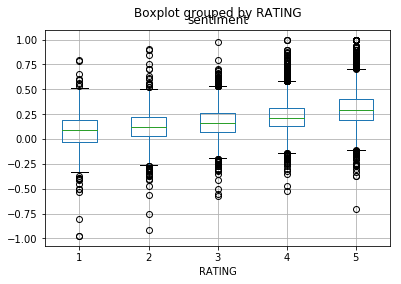

In [21]:
raw.boxplot(column='sentiment', by='RATING')

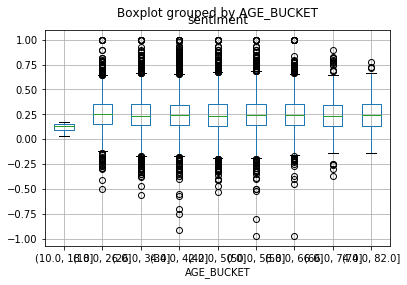

In [22]:
raw.boxplot(column='sentiment', by='AGE_BUCKET')

In [23]:
# Reviews with most positive sentiment
raw[raw.sentiment == 1].REVIEW.head()

198                                      For a now feel, that comfy and well made, this was a great choice!
263     This is a perfect jacket over any shirt, tee, or dress. jacket is well made and goes with anything!
859                                                                                            Great style!
1236                                       If there ever was the perfect feminine dress, this would be it .
2636                                                         This dress is so versatile. great summer wear!
Name: REVIEW, dtype: object

In [24]:
# Reviews with most negative sentiment
raw[raw.sentiment < -.8].REVIEW.head()

6296                                                              Awful color, horribly wrinkled and just a mess...so disappointed
14754                                                          Cut out design, no seems or hems.\r\n very disappointed in retailer
20502    Received this product with a gaping hole in it. very disappointed in the quality and the quality control at the warehouse
Name: REVIEW, dtype: object

In [187]:
# Widen the column display.
pd.set_option('max_colwidth', 500)

In [25]:
# Negative sentiment in a 5-star review
raw[(raw.RATING == 5) & (raw.sentiment < -0.3)].head(3)

,ID,AGE,TITLE,REVIEW,RATING,RECOMMENDED,POS_FEEDBACK,DIVISION,DEPARTMENT,CLASS,AGE_BUCKET,sentiment
4288,1078,28,Blank,"Casual comfort with style! fabric is a dream to wear and it flows nicely. not exactly form-fitting, but still flattering. i'm 5'9, 140, and wore the medium.",5,1,0,General,Dresses,Dresses,"(26.0, 34.0]",-0.375000
15707,1078,27,Blank,This dress is effortlessly chic. i wore it with black tights and booties and it was perfection. will definitely be a casual staple year around.,5,1,0,General,Dresses,Dresses,"(26.0, 34.0]",-0.333333
15843,936,40,Cute but not best quality,I would have bought this had it not been for the way the pockets are sewn in. they are attached on the inside by a string. if the string broke the pockets would dangle. for the price you would think they would have sewn pockets in to the vest. too bad.,5,1,2,General Petite,Tops,Sweaters,"(34.0, 42.0]",-0.700000


In [26]:
# Positive sentiment in a 1-star review
raw[(raw.RATING == 1) & (raw.sentiment > 0.5)].head(3)


,ID,AGE,TITLE,REVIEW,RATING,RECOMMENDED,POS_FEEDBACK,DIVISION,DEPARTMENT,CLASS,AGE_BUCKET,sentiment
1646,835,32,Pirate sleeves,"The beadwork is gorgeous, but the sleeves are so puffy, it looks as though you're wearing shoulder pads. the fabric of the shirt isn't that fabulous either.",1,0,0,General Petite,Tops,Blouses,"(26.0, 34.0]",0.550000
2243,870,43,Looks cheap,"I was excited to receive this top. it looked great online, vibrant colors with the beautiful detail on the sleeves. when i tried it on, the fabric looked and felt cheap. it is not a flowy top. do not recommend it.",1,0,0,General,Tops,Knits,"(42.0, 50.0]",0.513095
2427,939,39,Blank,Beautiful jacket and i got lots of compliments. true to size. it's not thick but it's very warm.,1,1,0,General,Tops,Sweaters,"(34.0, 42.0]",0.532500


### Flesch-Kincaid Readability with Textstat


In [57]:
from textstat.textstat import textstat

In [64]:
textstat.flesch_kincaid_grade(raw_small['REVIEW'].iloc[0])

11.9

In [69]:
# Define a function that accepts text and returns the grade level.
def detect_grade_level(text):
    return textstat.flesch_kincaid_grade(text)

In [70]:
# Create a new DataFrame column for grade level (Warning: SLOW!).
raw['grade_level'] = raw.REVIEW.apply(detect_grade_level)

In [74]:
raw.head(3)

,ID,AGE,TITLE,REVIEW,RATING,RECOMMENDED,POS_FEEDBACK,DIVISION,DEPARTMENT,CLASS,AGE_BUCKET,sentiment,grade_level
0,767,33,Blank,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates,"(26.0, 34.0]",0.633333,11.9
1,1080,34,Blank,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses,"(26.0, 34.0]",0.339583,3.8
2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - ...",3,0,0,General,Dresses,Dresses,"(58.0, 66.0]",0.073675,6.1


In [75]:
# Define a function that accepts text and returns the grade level.
def detect_readability(text):
    return textstat.flesch_reading_ease(text)

In [76]:
# Create a new DataFrame column for grade level (Warning: SLOW!).
raw['readability'] = raw.REVIEW.apply(detect_readability)

In [77]:
raw.head(3)


,ID,AGE,TITLE,REVIEW,RATING,RECOMMENDED,POS_FEEDBACK,DIVISION,DEPARTMENT,CLASS,AGE_BUCKET,sentiment,grade_level,readability
0,767,33,Blank,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates,"(26.0, 34.0]",0.633333,11.9,22.07
1,1080,34,Blank,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses,"(26.0, 34.0]",0.339583,3.8,86.40
2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - ...",3,0,0,General,Dresses,Dresses,"(58.0, 66.0]",0.073675,6.1,80.41


In [78]:

raw.to_csv('clothing reviews post python.csv')

In [79]:
# Reset the column display width.
pd.reset_option('max_colwidth')